# Segregation Simulation using cellular automata
### By Karan Shah

Includes:
* The Segregation of Dissimilarity as a measure of segregation
* Baseline model that runs till steady state or max iterations
* Interactive plot of the grid, and a realtime graph for Iterations vs. Index
* Plots for:
 * Grid size vs Index
 * Probability of Occupation ($\rho$) vs Index
 * Probability bias towards tribe A ($\alpha$) vs Index


In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from ipywidgets import interact
%matplotlib inline


#random.seed(1601134230)
np.random.seed(1601134230)
M, N = 10, 10
EMPTY = 0
TRIBE_A = 1
TRIBE_B = -1
PROB_OCCUPIED = 0.5
COND_PROB_A = 2.0 / 3
UNHAPPY_COLOR_THRESHOLD = 0
MAX_ITER = 100
DISTRIBUTION_TYPE = 0

In [2]:
def show_grid (grid):
    plt.matshow (grid)

In [3]:
def create_pop_grid (m, n, pr_occupied, pr_one):
    """
    Returns an (m+2) x (n+2) grid of integer cells, representing
    the population map of an abstract "world."
    
    Each cell contains one of three possible values: {-1, 0, +1}.
    The boundaries are set to 0, i.e., the world is "padded."
    
    In the interior, the probability that a cell is non-zero is
    pr_occupied. Cells are independent. The conditional
    probability that an occupied cell is +1 given that it is
    occupied is pr_one.
    """
    
    dims = (m+2, n+2)
    if(pr_occupied == 0):
        grid = np.zeros(dims)
    else:
        pr_a = pr_occupied * pr_one
        pr_b = pr_occupied * (1.0 - pr_one)
        pr_empty = (1.0 - pr_occupied)
    
        possible_values = np.array ([EMPTY, TRIBE_A, TRIBE_B])
        pr_dist = np.array ([pr_empty, pr_a, pr_b])
    
        grid = np.random.choice (possible_values, size=dims, p=pr_dist)
    
    # Fix the boundary
        grid[  0,   :] = 0
        grid[m+1,   :] = 0
        grid[  :,   0] = 0
        grid[  :, n+1] = 0
    
    return grid

This helper function calculates distance between two points.

In [4]:
def distance(x1,x2,y1,y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

This function initializes the grid population. In this implementation, the cell at the center of the grid is the seed. The probability of occupation decreases  linearly with the distance from the seed. This can be easily changed to inversely instead of linearly with a small modification.

In [5]:
def create_pop_grid_around_a_seed (m, n, pr_occupied, pr_one):
    seedm = m/2
    seedn = n/2
    dims = (m+2, n+2)
    x = random.random()
    rho = pr_occupied
    mu = max(distance(seedm, 0, seedn, 0),distance(seedm, m, seedn, 0),distance(seedm, 0, seedn, n),distance(seedm, m, seedn, n))
       # print(mu)
    grid = np.zeros(dims)
    
    if(pr_occupied != 0):
        for i in range(1,m+1):
            for j in range(1, n+1):
                if i != seedm or j != seedn:
                    x = random.random()
                    pr_occupied = rho*(mu - distance(seedm,i,seedn,j))/mu
                    #print(rho)
                    #print(pr_occupied)
                    if(x < pr_occupied):
                        #print (x < pr_occupied)
                        x = random.random()
                        if(x <= pr_one):
                            grid[i,j] = 1
                        if(x > pr_one):
                            grid[i,j] = -1
                        #pr_B = pr_occupied * (1 - pr_one)
    
    # Fix the boundary
        grid[  0,   :] = 0
        grid[m+1,   :] = 0
        grid[  :,   0] = 0
        grid[  :, n+1] = 0
    
    return grid


In [6]:
def normalize_neighborhoods (grid):
    # Given a grid of cells, normalize the value of each
    # grid cell by the count of its nearest neighbors.
    norm_grid = np.zeros (grid.shape)
    
    # Interior
    norm_grid[1:-1, 1:-1] = grid[1:-1, 1:-1] / 9
    
    # Edges
    norm_grid[1:-1, 0] = grid[1:-1, 0] / 6
    norm_grid[1:-1, -1] = grid[1:-1, -1] / 6
    norm_grid[0, 1:-1] = grid[0, 1:-1] / 6
    norm_grid[-1, 1:-1] = grid[-1, 1:-1] / 6
    
    # Corners
    norm_grid[0, 0] = grid[0, 0] / 4
    norm_grid[0, -1] = grid[0, -1] / 4
    norm_grid[-1, 1] = grid[-1, 0] / 4
    norm_grid[-1, -1] = grid[-1, -1] / 4
    
    return norm_grid

In [7]:
def measure_color (G, normalize=False):
    C = np.zeros (G.shape, dtype=G.dtype)
    
    r = len(G)
    c = len(G[0])
    
    for x in range(1, r-1):
        for y in range(1, c-1):
            C[x, y] = np.sum(G[(x-1):(x+2), (y-1):(y+2)])
    if normalize:
        C = C.astype (float)
        C[1:-1, 1:-1] = normalize_neighborhoods (C[1:-1, 1:-1])
        
    return C

In [8]:
def get_unhappy_grid (G, C, threshold=UNHAPPY_COLOR_THRESHOLD):
    # @YOUSE: Compute G_unhappy
    Happy = np.multiply(G, C)
    G_unhappy = np.multiply(G, Happy < threshold) # Replace this statement with solution code
    
    return G_unhappy

In [9]:
def get_locations (condition_grid):
    """
    Given a grid of True/False values, returns a
    list of tuples [..., (i, j), ...], where each
    tuple is the location of a True value.
    """
    locs = np.nonzero (condition_grid)
    return list (zip (locs[0], locs[1]))

In [10]:
def is_free_grid (pop_grid):
    free_spaces = np.zeros (pop_grid.shape, dtype=bool)
    free_spaces[1:-1, 1:-1] = (pop_grid[1:-1, 1:-1] == 0)
    return free_spaces

In [11]:
def swap_grid_random (G, locs_x, locs_y):
    """
    Given a grid and two possible collections of locations, X and Y,
    this routine randomly swaps as many locations from X with those
    from Y. This routine performs the swaps *in-place*, that is, it
    modifies grid directly.
    """
    
    # Max swaps possible
    n = min (len (locs_x), len (locs_y))
    
    # Choose random entries to swap
    locs_x_to_swap = random.sample (locs_x, n)
    locs_y_to_swap = random.sample (locs_y, n)
    
    # Execute swaps
    for ((xi, xj), (yi, yj)) in zip (locs_x_to_swap, locs_y_to_swap):
        G[xi, xj], G[yi, yj] = G[yi, yj], G[xi, xj]
        
    return G

In [12]:
def calcIndex(m, n,G):
    peeps = np.copy(G)
    noA= np.count_nonzero (peeps == 1)
    noB= np.count_nonzero (peeps == -1)
    if noA ==0 and noB == 0: return 0
    elif noA == 0: return 1
    elif noB == 0: return 1
    else:     
        totalCells = m*n
        km = m - m%3 #9
        kn = n - n%3 #9
           # print("km,kn=",km,kn)
        noLeft = totalCells - (km * kn)
           # print("Left=",noLeft)
        newG = peeps[1:km+1,1:kn+1]
        left = np.copy(G)
        left[1:km+1,1:kn+1] = 0
    #show_grid(left)
    #  print(np.shape(peeps))
          #  print(np.shape(newG))
    #show_grid(newG)
    
        noAi = np.count_nonzero (left == 1)
        noBi = np.count_nonzero (left == -1)
        tempI = abs(noAi/noA - noBi/noB)#*9/noLeft
        #print (tempI)
        index = tempI
        for i in range(1,m,3):
            for j in range(1,n,3):
                noAi = np.count_nonzero (newG[i-1:i+1,j-1:j+1] == 1)
                noBi = np.count_nonzero (newG[i-1:i+1,j-1:j+1] == -1)
                index = index + abs(noAi/noA - noBi/noB) 

    #show_grid(newG)
    #index = 0
    
        return index/2
    return 0
    

In [13]:
def baseline(G, threshold):
    #Run iterations
    peeps = G
    raw_color_grid = measure_color (peeps)
    norm_color_grid = measure_color (peeps, normalize = True)
    
    unhappy_campers = get_unhappy_grid (peeps, norm_color_grid)
    
    locs_unhappy_A = get_locations (unhappy_campers == 1)
    locs_unhappy_B = get_locations (unhappy_campers == -1)
    
    avail_grid = is_free_grid (peeps)
    
    appeals_to_A = (norm_color_grid >= threshold)
    locs_appeal_to_A = get_locations (avail_grid & appeals_to_A)
    
    appeals_to_B = (norm_color_grid <= -threshold)
    locs_appeal_to_B = get_locations (avail_grid & appeals_to_B)
    
    new_peeps = np.copy (peeps)
    swap_grid_random (new_peeps, locs_unhappy_A, locs_appeal_to_A)
    swap_grid_random (new_peeps, locs_unhappy_B, locs_appeal_to_B)
    
    return new_peeps

This is the non interactive main function for plotting and testing purposes.

In [14]:
#Signature: main(m,n,prob_occupied, prob(A), threshold, distributionType)
def main(m = M, n = N, max_steps=MAX_ITER, p_occupied=PROB_OCCUPIED, p_A=COND_PROB_A, threshold=UNHAPPY_COLOR_THRESHOLD, distribution = 0):
    #np.random.seed (seed)
    np.random.seed(1601134230)
    if(distribution == 0):
        peeps = create_pop_grid (m, n, p_occupied, p_A)
    else:
        peeps = create_pop_grid_around_a_seed (m, n, p_occupied, p_A)
    og = peeps
    #print("Initial grid:")
    #show_grid(peeps)
    
    nextpeeps = baseline(peeps, threshold)
    steady = (peeps==nextpeeps).all()
    i = 1
    
    while(not(steady) and (i < max_steps)):
        peeps = nextpeeps
        nextpeeps = baseline(peeps, threshold)
        i=i+1
        steady = (peeps==nextpeeps).all()
    
    # print("Final result:")
    # print("Iterations:",i)
    # show_grid(nextpeeps)
    
    ini = calcIndex(m,n,og)
    fin = calcIndex(m,n,nextpeeps)
    if(ini==0): per = 0
    else: per = (fin - ini)*100/ini
    # print("INdex for initial, final:", ini,fin)
    # print("Percentage change:",per)
    return fin #For plotting index, replace with i for iterations

This is the interactive main version that plots an Iterations vs. Index graph, prints segregation statistics,and  plots initial and final grids.   Default distribution type is baseline model uniformly random distribution.

Note: Distribution: 0 for baseline uniform, 1 for distribution around a seed

Initial:
Population of A: 35
Population of B: 16

Final result:
Population of A: 35
Population of B: 16

Index for initial, final: 0.18125 0.2910714285714286
Percentage change: 60.59113300492612 %


<function __main__.imain>

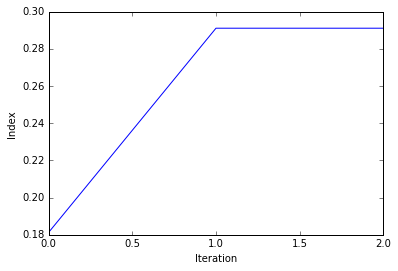

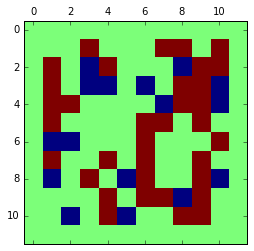

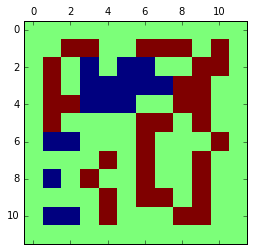

In [15]:

def imain (m = M, n = N, max_steps=MAX_ITER, p_occupied=PROB_OCCUPIED, p_A=COND_PROB_A, threshold=UNHAPPY_COLOR_THRESHOLD, distribution = DISTRIBUTION_TYPE):
    #np.random.seed (seed)
    np.random.seed(1601134230)
    #print("test")
    if(distribution == 0):
        peeps = create_pop_grid (m, n, p_occupied, p_A)
    else:
        peeps = create_pop_grid_around_a_seed (m, n, p_occupied, p_A)
    #print (peeps)
    og = peeps
    
    finValues = [calcIndex(m,n,og)]
    noA= np.count_nonzero (peeps == 1)
    noB= np.count_nonzero (peeps == -1)
    
    nextpeeps = baseline(peeps, threshold)
    steady = (peeps==nextpeeps).all()
    i = 1
    
    finValues.append(calcIndex(m,n,nextpeeps))
    
    while(not(steady) and (i < max_steps)):
        peeps = nextpeeps
        nextpeeps = baseline(peeps, threshold)
        i=i+1
        finValues.append(calcIndex(m,n,nextpeeps))
        steady = (peeps==nextpeeps).all()
    
    print("Note: Distribution: 0 for baseline uniform, 1 for distribution around a seed")
    print("\nInitial:")
    print("Population of A:", noA)
    print("Population of B:", noB)
    print("\nFinal result:")
    noA= np.count_nonzero (nextpeeps == 1)
    noB= np.count_nonzero (nextpeeps == -1)
    print("Population of A:", noA)
    print("Population of B:", noB)
    ini = finValues[0]
    fin = finValues[-1]    
    if(ini==0): per = 0
    else: per = (fin - ini)*100/ini
    
    it = range(0,i+1,1)
    plt.xlabel('Iteration')
    plt.ylabel('Index')
    plt.plot(it,finValues)
    plt.matshow(og)
    plt.matshow(nextpeeps)
    print("\nIndex for initial, final:", ini,fin)
    print("Percentage change:",per,"%")

    
   
interact (imain
          , m=(10, 50, 5)
          , n=(10, 50, 5)
          , max_steps=(1, 100, 5)
          , p_occupied=(0.0, 1.0, 0.1)
          , p_A=(0.0, 1.0, 0.1)
          , threshold=(0.0, 1.0, 0.1)
          , distribution=(0,1.0,1)
         )

### Plots
This section has the code for making plots. It won't start plotting by default (saves time and space). Change the variable to_plot to 1 and run to start plotting. Change the modes (1 iteration/ multi) or (normal/seeded distribution).

In [16]:
to_plot = 0 #Set 1 to start plotting
max_step = 100 #Set one for only one iteration
distribution = 0 #0 for normal, 1 for seeded

In [17]:
#Grid size plot
if to_plot == 1:

    xx = range(10,101,10)
    yy = np.array(xx,dtype=float)
    for i in range(0,len(xx)):
        yy[i] = main(xx[i],xx[i],max_step,PROB_OCCUPIED,COND_PROB_A,UNHAPPY_COLOR_THRESHOLD,distribution)
    
    #print(yy)
    plt.xlabel('Grid size')
    plt.ylabel('Index')
    plt.plot(xx,yy)
    print("Baseline Model Grid size vs Index Plot\nConditions:\nStep Size: 0.1\nIterations: 1\nPr(Occ)=0.5\nPr(A):0.66")


In [18]:
#Pr(Occ) plot
if to_plot == 1:
    xx0 = np.arange(0.0,1.001,0.1)

    yy0 = np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yy0[i] = main(100,100,1,xx0[i],0.25,UNHAPPY_COLOR_THRESHOLD,distribution)
    
    yy1 = np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yy1[i] = main(100,100,1,xx0[i],0.5,UNHAPPY_COLOR_THRESHOLD,distribution)

    yy2 = np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yy2[i] = main(100,100,1,xx0[i],0.75,UNHAPPY_COLOR_THRESHOLD,distribution)
    
    yyb =np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yyb[i] = main(100,100,1,xx0[i],COND_PROB_A,UNHAPPY_COLOR_THRESHOLD,distribution)

    yyallB =np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yyallB[i] = main(100,100,1,xx0[i],0,UNHAPPY_COLOR_THRESHOLD,distribution)
    
    yyallA =np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yyallA[i] = main(100,100,1,xx0[i],1,UNHAPPY_COLOR_THRESHOLD,distribution)
    
    plt.xlabel('Probability of occupation')
    plt.ylabel('Index')
    plt.plot(xx0,yy0,'c',xx0,yy1,'m',xx0,yy2,'g',xx0,yyb,'y',xx0,yyallA,'r',xx0,yyallB,'b')
    print("Baseline Model Pr(Occupation) vs Index Plot\nConditions: \nGrid size: 100x100\nStep Size: 0.1\nIterations: 1")
    print("Pr(A):\n\tRed:All A,\n\tBlue:All B,\n\tCyan:0.25,\n\tMagenta:0.5,\n\tYellow:0.66(Default),\n\tGreen:0.75")



In [19]:
#Pr(A) plot
if to_plot == 1:
    xx0 = np.arange(0.0,1.001,0.1)

    yy0 = np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yy0[i] = main(100,100,1,0.25,xx0[i],UNHAPPY_COLOR_THRESHOLD,distribution)

    yy1 = np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yy1[i] = main(100,100,1,PROB_OCCUPIED,xx0[i],UNHAPPY_COLOR_THRESHOLD,distribution)

    yy2 = np.array(xx0,dtype=float)
    for i in range(0,len(xx0)):
        yy2[i] = main(100,100,1,0.75,xx0[i],UNHAPPY_COLOR_THRESHOLD,distribution)

    plt.xlabel('Pr(A)')
    plt.ylabel('Index')
    plt.plot(xx0,yy0,'r',xx0,yy1,'b',xx0,yy2,'g')
    print("Baseline Model Pr(A) vs Index Plot\nConditions: \nGrid size: 100x100\nStep Size: 0.1\nIterations: 1")
    print("Pr(Occupied):\n\tRed:0.25,\n\tBlue:0.5,\n\tGreen:0.75")